In [88]:
try:    
    import alpaca_trade_api
except:
    !pip install PyYAML==5.4.1 --ignore-installed
    !pip install alpaca_trade_api
try:
    import stldecompose
except:
    !pip install scipy==1.2.1
    !pip install statsmodels==0.10.2
    !pip install stldecompose==0.0.5
try:    
    import xgboost 
except:
    !pip install PyYAML==5.4.1 --ignore-installed  
    
from sklearn.preprocessing import MinMaxScaler
import ApiClient as ac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stldecompose import decompose
from sklearn.svm import LinearSVC
from stldecompose.forecast_funcs import mean
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df= client.get_closing_price(ticker,255)
df.index=pd.to_datetime(df.index,utc=True)
split=int(df.shape[0]*7/12)
stl = STL_strategy(ticker,df)  

temp_x,temp_y = stl.transfor(df)
x0 = temp_x[:split]
x1 = temp_x[split-5:]
y0 = temp_y[:split]
y1 = temp_y[split-5:]
'''    
train_ = df.iloc[:split]
test_ = df.iloc[split-5:]      
x0,y0 = stl.transfor(train_)
x1,y1 = stl.transfor(test_)
'''
a,b=stl.model_selection(x0,y0,x1,y1)

In [293]:
a=3.02565
print('da:{:.2f}'.format(a))

da:3.03


In [295]:
print("Profit based on STL ML: %.2f" %a)

Profit based on STL ML: 3.03


In [303]:
class STL_strategy():
    def __init__ (self,ticker,df,column='close',cycle=10,period=2):
        self.ticker = ticker
        self.column = column
        self.period = period
        self.cycle = cycle
        self.df = df
        self.df.index=pd.to_datetime(df.index,utc=True)
        
    # generate features and labels beased on stl
    # return histories of the day =>features
    #        the day's trading possible
    def transfor (self,x):
        #print(x.shape)
        transfor_x = pd.DataFrame(index=x.index[self.period:],columns=[i for i in range(self.period+2)]) 
        olders = decompose(x[['close']], self.cycle)
        scaler = MinMaxScaler(feature_range=(-1, 1))
        last_close = scaler.fit_transform(x[['close']])
        last_open = scaler.fit_transform(x[['open']])
        resid = scaler.fit_transform(olders.resid[['close']])
        middle = np.mean(resid)
        #plt.plot(resid)
        
        # features will be (last 5 days residual history from stl, last day close and open price)
        for i in range(transfor_x.shape[0]):
            hist = []
            for value in resid[i:i+self.period]:
                hist.append(value[0])
            hist.append(last_close[i+self.period-1][0])
            hist.append(last_open[i+self.period][0])
            
            transfor_x.loc[transfor_x.index[i]]=hist
        resid_checking = resid[self.period:].flatten()
        #print(resid_checking.shape)
        
        # multiple method to get labels
        # 0) Finding Peaks and troughs marke as sell and buy points by min/max nearby points
        '''    
        ema_y=[0]   
        hold = 0        
        for i in range (1,(resid_checking).shape[0]):
            #sell
            if resid_checking[i] == np.max(resid_checking[i-1:i+2]) and  hold != 0 :
                ema_y.append(-1)
                hold = 0
            #buy
            elif resid_checking[i] == np.min(resid_checking[i-1:i+2]) and hold == 0 :
                ema_y.append(1)
                hold = 1
            else:
                ema_y.append(0) 
        transfor_y =  np.array(ema_y,dtype='int') 
        '''
        # 1) Finding shift Peaks and troughs marke as sell and buy points by scipy.signal.argrelextrema
        ''' 
        mix_index = argrelextrema(
            resid_checking, np.less_equal, order=4)[0]
        max_index = argrelextrema(
            resid_checking, np.greater_equal, order=4)[0]
        z= np.zeros_like(resid_checking)
        z[max_index] = -1
        z[mix_index] = 1    
        transfor_y =  np.array(z,dtype='int') 
        ''' 
        # 2) Dividing  to three parts baseed on total mean of residual, sell/hold/buy
        #     Then sanitize, no sell before buy and only one buy before sell
        #'''   
        # create raw labels   
        preid = []
        self.ch = resid_checking
        for i in range (resid_checking.shape[0]):
            #sell
            if resid_checking[i]>middle+0.1:
                preid.append(-1)
            #buy
            elif resid_checking[i]<middle-0.1:
                preid.append(1)
            else:
                preid.append(0)       
        hold = 0
        pre_buy = 1
        predict=[]             
        price_check = self.df.iloc[-len(preid):]
        #print(price_check.shape,len(preid))
        
        # sanitize labels
        for index,i in enumerate(preid):
            #Sell
            if (i ==-1 or np.log(price_check.close[index]/pre_buy)<-0.02 or np.log(price_check.close[index]/pre_buy)>0.02 )  and hold ==1 :
                predict.append(-1)
                hold = 0
            #Buy
            elif i ==1 and hold ==0:
                predict.append(1)
                hold = 1
                pre_buy = price_check.close[index]
            #Hold
            else:
                predict.append(0)
        transfor_y =  np.array(preid,dtype='int')        
        #'''
        
        #self._plot(self.df,transfor_y)
        #print('result',transfor_x.iloc[:-1].shape,transfor_y[1:].shape) 
        return transfor_x.iloc[:-1],np.array(transfor_y[1:])

    # Test which ML will be the best
    def model_selection(self,x0,y0,x1,y1):
        models = []
        #models.append(('LR', LogisticRegression(max_iter=3000)))
        #models.append(('LDA', LinearDiscriminantAnalysis()))
        #models.append(('KNN', KNeighborsClassifier()))
        #models.append(('CART', DecisionTreeClassifier()))
        #models.append(('NB', GaussianNB()))
        #models.append(('SVM', SVC()))
        #models.append(('RFT', RandomForestClassifier()))
        models.append(('LinearSVC', LinearSVC(max_iter=3000)))

        results = []
        names = []
        for name, model in models:
            #print("che")
            model.fit(x0,y0)
            preid = model.predict(x1)
            #print("cking")
               
            
            predict = self.regulate(self.df,preid) 
            profit_results = self.publish_trading_strategy(self.df,predict)            
            results.append(profit_results)
            names.append(name)
            print(name,profit_results)
            #print(name)
            self._plot(self.df,preid)
            
        return results, names
    
    # Wrap anything to post backtest profit
    def backtest(self):
        split=int(self.df.shape[0]*7/12)
        train_ = self.df.iloc[:split]
        test_ = self.df.iloc[split-5:]      
        x0,y0 = self.transfor(train_)
        x1,y1 = self.transfor(test_)
        self.fit(x0,y0)
        preid = self.predict(x1)
        predict = self.regulate(self.df,preid) 
        profit_results = self.publish_trading_strategy(self.df,predict)          
        print("Profit based on STL ML at last 5 months: %.2f" %(profit_results))
        self._plot(self.df,predict)
        return profit_results
        
    # train STL ML
    def fit(self,x0,y0):
        self.model=LinearSVC(max_iter=3000) 
        self.model.fit(x0,y0)
    
    # predict every buy and sell possible throught STL ML  
    def predict(self,x1):
        preid = self.model.predict(x1) 
        return preid    
      
    # Wrap anything to post today's trading strategy
    def strategy(self):
        split=int(self.df.shape[0]*7/12)
        train_ = self.df.iloc[:split]
        test_ = self.df.iloc[split-5:]      
        x0,y0 = self.transfor(train_)
        x1,y1 = self.transfor(test_)
        self.fit(x0,y0)
        preid = self.predict(x1)            
        return preid[-1]         
    
    # sanitize extra buy and sell and prevention of excessive losses
    def regulate(self,price,predict):
        close_price = price.iloc[-len(predict[:-1]):]
        hold = 0
        pre_buy = 1
        predict_new=[]     
        
        for index,i in enumerate(predict[:-1]):
            #Sell 
            if (i ==-1 or np.log(close_price.close[index]/pre_buy)<-0.02 )  and hold ==1 :
                predict_new.append(-1)
                hold = 0
            #Buy
            elif i ==1 and hold ==0:
                predict_new.append(1)
                hold = 1
                pre_buy = close_price.close[index]
            #Hold
            else:
                predict_new.append(0)
        position =  np.array(predict_new,dtype='int')
        return position
    
    # produce  profit            
    def publish_trading_strategy (self,price,predict):  
        position = predict[:-1]
        close_price = price.iloc[-len(position):]
        
        sell = close_price.close[position == -1.0]
        buy = close_price.close[position == 1.0]
        self.profit = 0
        for i in range(sell.shape[0]):
            self.profit +=np.log(sell[i]/buy[i])
        return self.profit
    
    # plot close price and strategy
    def  _plot (self,close_price,predict):
        position = predict[:-1]
        x = close_price.iloc[-len(position):]
        plt.figure(figsize = (20,6))
        close_price[self.column].plot(color = 'k', label= self.column) 
        
        #plot sell        
        plt.plot(x.loc[position == -1.0].index, 
                 x.close[position == -1.0],'v', 
                 markersize=15, color='r', label="Sell")
        #plot buy        
        plt.plot(x.loc[position == 1.0].index, 
                 x.close[position == 1.0],'^', 
                 markersize=15, color='g', label="Buy") 
        plt.ylabel('Price($)', fontsize = 15 )
        plt.xlabel('Date', fontsize = 15 )
        plt.title(self.ticker, fontsize = 20)
        plt.legend()
        plt.grid()
        plt.show() 

In [ ]:
df= client.get_closing_price("GOOG",255)
curr = STL_strategy("GOOG",df,'close',10,3)  
curr.strategy

Profit based on STL ML at last 5 months: 0.24


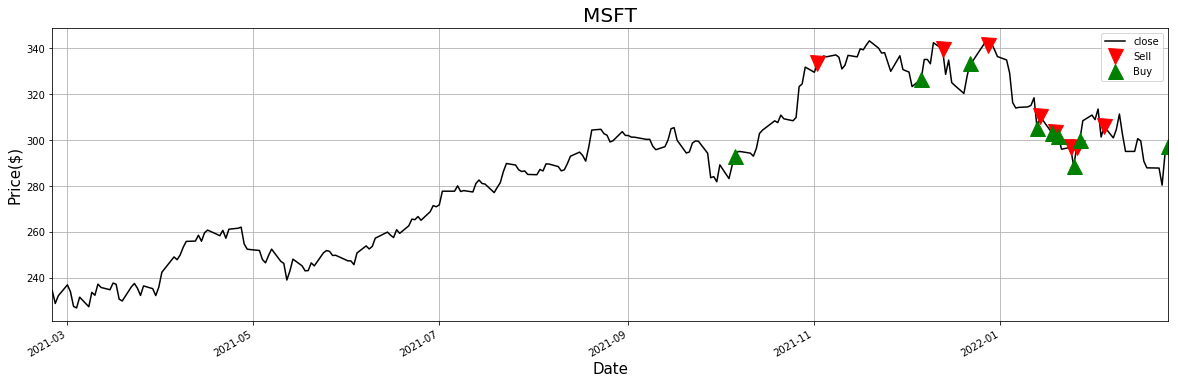

Profit based on STL ML at last 5 months: 0.24


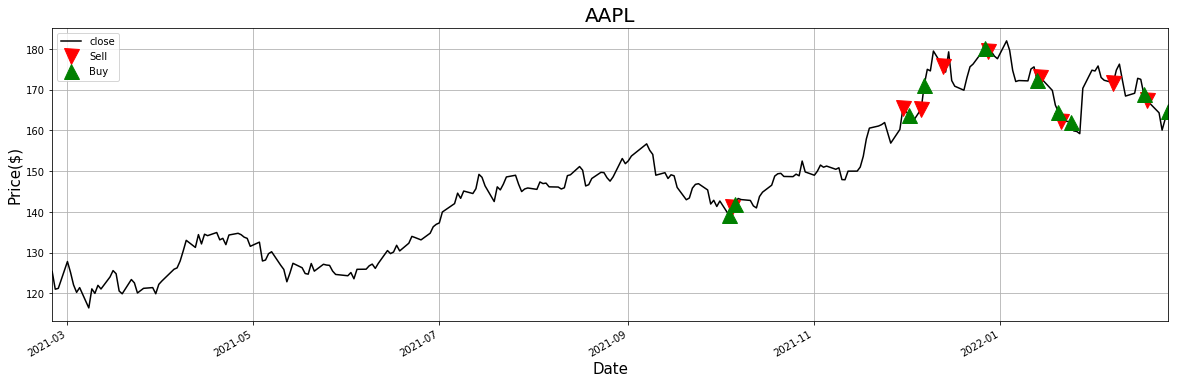

Profit based on STL ML at last 5 months: 0.08


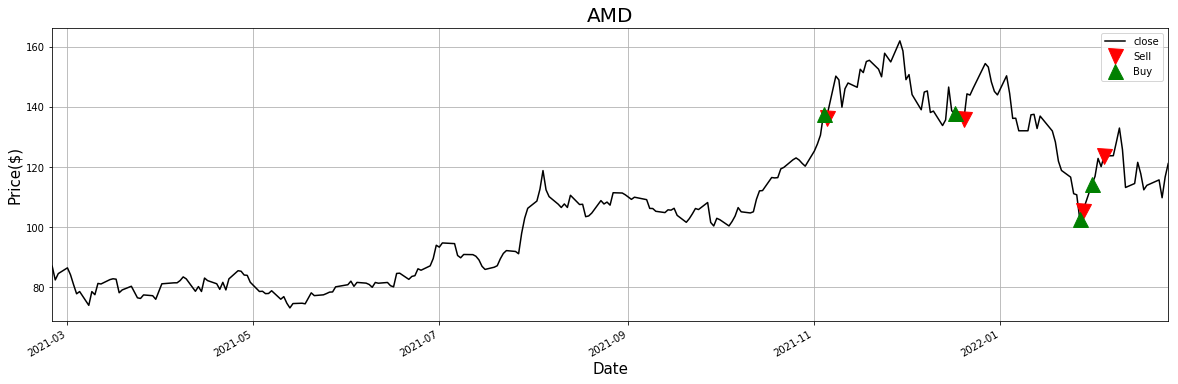

Profit based on STL ML at last 5 months: 0.16


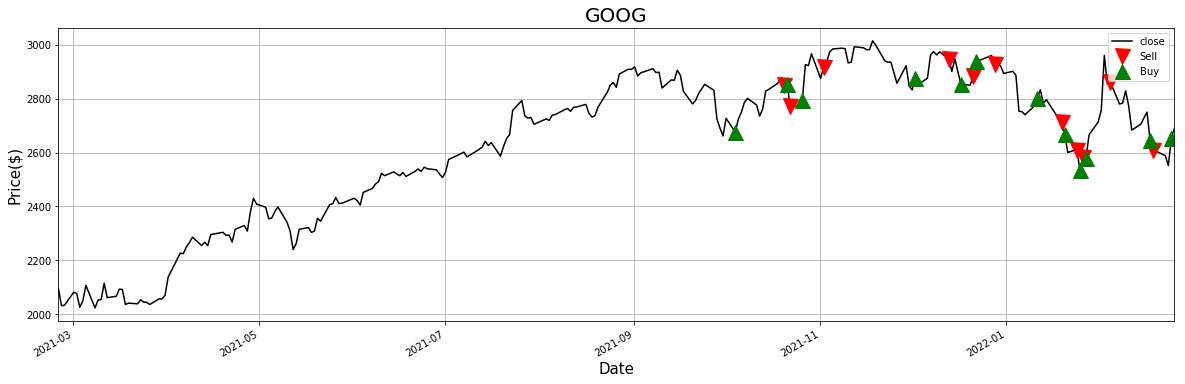

Profit based on STL ML at last 5 months: 0.12


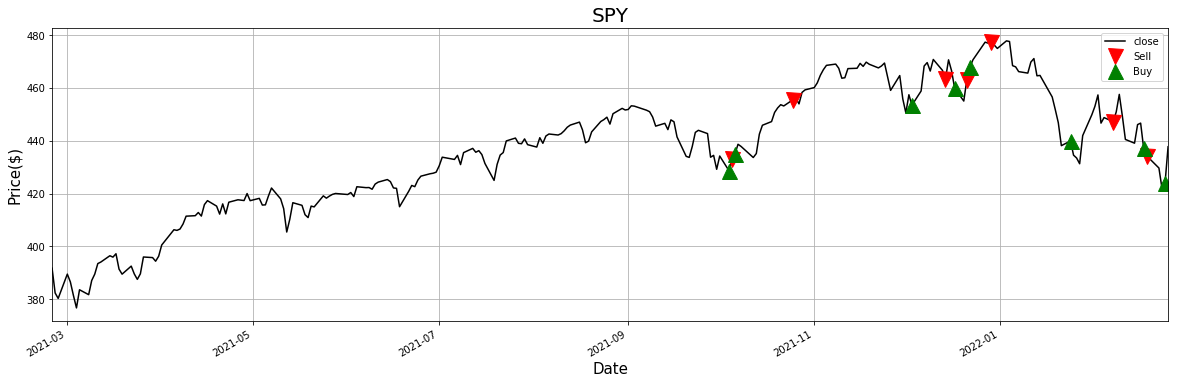

0.8395040310801496
totl [0. 0. 0. 0. 0. 0. 0. 0.]


In [313]:
import time
totl = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])#])
a = 0
client = ac.ApiClient('PKQLM6IO3KNXCFQ17U0G','ZTzKsxn7uEaSvCGG8SVmqZR5PBGps9nR9WHLPkNF')
for s,ticker in enumerate([ "MSFT","AAPL","GM","GOOG","TSLA"]):
    df= client.get_closing_price(ticker,255)
    df.index=pd.to_datetime(df.index,utc=True)
    split=int(df.shape[0]*7/12)
    stl = STL_strategy(ticker,df,'close',10,3)  
    '''
    temp_x,temp_y = stl.transfor(df)
    x0 = temp_x[:split]
    x1 = temp_x[split-5:]
    y0 = temp_y[:split]
    y1 = temp_y[split-5:]
       
    train_ = df.iloc[:split]
    test_ = df.iloc[split-5:]      
    x0,y0 = stl.transfor(train_)
    x1,y1 = stl.transfor(test_)    
    a,b=stl.model_selection(x0,y0,x1,y1)
    totl +=np.array(a)
    '''
    
    
    a += stl.backtest()
    
    
    #time.sleep(3)
print(a)    
print('totl',totl)

In [5]:
import pandas as pd
import numpy as np
import TradingStrategy as tStrategy
import Common.DatetimeUtility as du
from datetime import datetime
from dateutil import tz
from STL.StlMl import STL_strategy
import time
stock="GOOG"
stratgies=tStrategy.TradingStrategy(stock,'stl')
stratgies.client.list_positions()

RecursionError: maximum recursion depth exceeded